# 2. Simple ITK
#### [Python and Jupyter Notebook for Medical Image Analysis](https://github.com/sbonaretti/2020_OpenMR_jupyter)
#### [OpenMRBenelux](https://openmrbenelux.github.io/) Workshop - January 22, 2020 - Nijmegen (The Netherlands)

---

We have three images: 
- A dicom stack of a knee (`knee`)
- A mask of femoral knee cartilage computed with our latest segmentation algorithm (`mask.mha`) 
- A ground truth segmentation (`mask_gt.mha`). 

We want:
1. Visually evaluate the quality of the segmentation
2. Compute the difference between the two segmentations in terms of overlapping voxels
2. Compute the difference between the cartilage volumes calculated from the two masks (in [mm])

Through this task we will learn how to: 
- Read a dicom stack  
- Read a metafile image 
- Print out image characteristics
- Visualize an image
- Use a filter (e.g Dice Similarity Coefficient)
- Calculate mask volume

Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

from ipywidgets import * # for display
from ipywidgets import HBox, VBox
from ipywidgets import interactive
from ipywidgets import Layout
from ipywidgets import widgets as widgets

Functions:

In [2]:
def show_image_slice(slice):
    
    """
    Show one slice of an image
    Input: 2D slice in SimpleITK format
    """
    
    # figure size in notebook
    plt.rcParams['figure.figsize'] = [5, 5]

    # -> Task 1: Note the function GetArrayViewFromImage. What does it do? 
    np_slice = sitk.GetArrayViewFromImage(slice)     
    
    # flip the slice upside-down for visualization
    np_slice = np.flipud(np_slice)
    
    # plot with matplotlib
    plt.imshow(np_slice, 'gray', interpolation=None, origin='lower')
    plt.axis('off')
    plt.show()

In [3]:
def show_image_interactive (img, mask=None):  
    
    """
    Show image using slider 
    Inputs: 
    - 3D image in SimpleITK format
    - 3D mask in SimpleITK format (optional)
    """  
    
    # convert image to numpy array for compatibility with matplotlib
    np_img  = sitk.GetArrayViewFromImage(img)
    if mask != None:
        np_mask = sitk.GetArrayViewFromImage(mask)
        
    
    # variables 
    n_of_slices = np_img.shape[0]
    first_slice_viz = 30
    
        
    # function for slider
    def view_image(slider):
        
        # get slice of image
        slice_np_img = np_img[slider,:,:] 
        
        # flip the slice upside-down for visualization
        slice_np_img = np.flipud(slice_np_img)
        
        if mask != None: 
            # get slice of ,asl
            slice_np_mask = np_mask[slider,:,:]
            # flip the slice upside-down for visualization
            slice_np_mask = np.flipud(slice_np_mask)
            # mask for transparency
            slice_np_mask = np.ma.masked_where(slice_np_mask == 0, slice_np_mask)

        # show both
        plt.imshow(slice_np_img, cmap=plt.cm.gray, origin='lower',interpolation=None) 
        if mask != None: 
            plt.imshow(slice_np_mask, 'hsv' , interpolation=None, origin='lower', alpha=1, vmin=0, vmax=100) 
        plt.axis('off')

        
    # link sliders and its function
    slider_image = interactive(view_image, 
                         slider = widgets.IntSlider(  min     = 0, 
                                                      max     = n_of_slices, 
                                                      value   = first_slice_viz,
                                                      step    = 1,
                                                      layout  = Layout(width='180px'),
                                                      readout = False,
                                                      continuous_update = False, # avoids intermediate image display,
                                                      description       = 'Slice n.'))
    # show figures before start interacting
    slider_image.update()  
    
    # slice number scrolling
    text = widgets.BoundedIntText( min    = 0, 
                                   max    = n_of_slices, 
                                   value  = first_slice_viz,
                                   step   = 1,
                                   layout = Layout(width='50px'),
                                   continuous_update = False, 
                                   description       = "") # BoundedIntText to avoid that displayed text goes outside of the range)
    
    # link slider and text 
    widgets.jslink((slider_image.children[:-1][0], 'value'), (text, 'value'))
    
    # layout
    slider_box   = HBox(slider_image.children[:-1])
    widget_box   = HBox([slider_box, text])
    whole_box    = VBox([widget_box, slider_image.children[-1] ]) 
        
    return whole_box

---

## 1. Visually evaluate the quality of the segmentations

### Read the knee stack (dicom)

Variable:

In [4]:
image_folder = "./data/knee" 

-> Read the dicom series: 

In [5]:
reader      = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames( image_folder )  # -> Task 1: Add folder name between the brackets
reader.SetFileNames(dicom_names)
img         = reader.Execute()

-> Print image characteristics:

In [6]:
print("Origin : " + str(img.GetOrigin()))    
print("Spacing: " + str(img.GetSpacing()))
print("Size   : " + str(img.GetSize()  ))      # -> Task 1: Get image origin using GetSize()

Origin : (-4.937600135803223, -57.961299896240234, 86.4000015258789)
Spacing: (0.3125, 0.3125, 1.5)
Size   : (512, 512, 68)


Visualize one image slice:

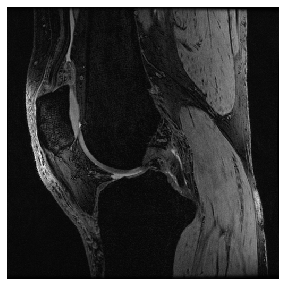

In [7]:
slice_id = 30
slice = img[:,:,slice_id]
show_image_slice (slice)  # Task 1: Have a look at the function show_image_slice

Browse the 3D image:

In [8]:
show_image_interactive(img)

### Read `mask.mha`

Read the metafile:

In [9]:
mask = sitk.ReadImage("./data/mask.mha")

Browse the 3D image and the mask:

In [10]:
show_image_interactive(img, mask)

### Read `mask_gt.mha`

-> Read the metafile:

In [11]:
mask_gt = sitk.ReadImage("./data/mask_gt.mha")   # -> Task 1: Write the function to read the ground truth mask 

-> Browse the 3D image and the mask:

In [12]:
show_image_interactive(img, mask_gt)             # -> Task 1: Write the function to browse the image with the ground truth mask 

## 2. Compute the difference between the two segmentations in terms of overlapping voxels

-> We need to calculate the Dice Similarity Coefficient

In [13]:
# Declare the filter 
filter     = sitk.LabelOverlapMeasuresImageFilter()

# Execute the filter 
filter.Execute( mask, mask_gt ) # Task 1: What are the inputs?

# Get the DSC and print it out
dice_coeff = filter.GetDiceCoefficient()
print ("The Dice Similarity Coefficient is :" + "{:.2f}".format(dice_coeff))

The Dice Similarity Coefficient is :0.99


## 3. Computer the difference between the cartilage volumes calculated from the two masks (in [mm])

-> Calculate volume for `mask.mha`

In [14]:
# sitk to numpy
mask_py = sitk.GetArrayFromImage(mask)

# get number of white voxels
n_of_voxels = np.count_nonzero(mask_py)

# calculate volume in voxels
volume_vx = n_of_voxels

# calculate volume in mm 
volume_mm = volume_vx * mask.GetSpacing()[0] * mask.GetSpacing()[1] * mask.GetSpacing()[2]            # -> Task 1: calculate volume in mm given volume in voxels

# print out volume
print ("The volume is: " + "{:.2f}".format(volume_mm) + " [mm]")

The volume is: 11582.23 [mm]


-> Calculate volume for mask_gt.mha

In [15]:
# sitk to numpy
mask_gt_py = sitk.GetArrayFromImage(mask_gt)

# get number of white voxels
n_of_voxels = np.count_nonzero(mask_gt_py)

# calculate volume in voxels
volume_vx = n_of_voxels

# calculate volume in mm 
volume_mm =  volume_vx * mask_gt.GetSpacing()[0] * mask_gt.GetSpacing()[1] * mask_gt.GetSpacing()[2]              # -> Task 1: calculate volume in mm given volume in voxels (same as above)

# print out volume
print ("The volume is: " + "{:.2f}".format(volume_mm) + " [mm]")

The volume is: 11729.59 [mm]


-> Alternative way to avoid rewriting the same commands?

In [16]:
def calculate_volume(mask): 
    
    """
    Function to calculate cartilage volume
    It calculates the number of mask voxels and then multiply them by image spacing
    Input: 
    - mask: binary mask in SimpleITK 
    Output:
    - volume_mm: float
    """
    
    # write function here
    mask_gt_py = sitk.GetArrayFromImage(mask)

    # get number of white voxels
    n_of_voxels = np.count_nonzero(mask_gt_py)

    # calculate volume in voxels
    volume_vx = n_of_voxels

    # calculate volume in mm 
    volume_mm =  volume_vx * mask.GetSpacing()[0] * mask.GetSpacing()[1] * mask.GetSpacing()[2]             # -> Task 1: calculate volume in mm given volume in voxels (same as above)

    # print out volume
    print ("The volume is: " + "{:.2f}".format(volume_mm) + " [mm]")
    
    return volume_mm


Calculate volumes using function:

In [21]:
vol    = calculate_volume(mask)

The volume is: 11582.23 [mm]


In [22]:
vol_gt = calculate_volume(mask_gt)

The volume is: 11729.59 [mm]


-> Calculate volume difference:

In [23]:
diff =   vol - vol_gt      # -> Task 1: calculate volume difference

In [24]:
print ("The volume difference is: " + "{:.2f}".format(diff) + " [mm]")

The volume difference is: -147.36 [mm]


---

## Dependencies

In [25]:
%load_ext watermark
%watermark -v -m -p numpy,matplotlib,SimpleITK
%watermark -u -n -t -z 

CPython 3.7.4
IPython 7.8.0

numpy 1.17.2
matplotlib 3.1.1
SimpleITK 1.2.4

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
last updated: Wed Jan 22 2020 15:14:21 CET
